In [1]:
import pandas as pd
#j'importe les données
df_dist = pd.read_csv("distance_from_vax.csv", dtype={"InputID" : str}) #table des distance calculée avec Qgis
df_pop = pd.read_csv("base-ic-evol-struct-pop-2017_csv/base-ic-evol-struct-pop-2017.CSV",sep=";",dtype={"IRIS" : str,"COM" : str}) #population par Iris
df_corr = pd.read_excel("table-appartenance-geo-communes-21.xlsx",skiprows=5,dtype={"CODGEO" : str, "EPCI" : str}) #table de corresponde Iris-Commune-EPCI
df_vax = pd.read_csv("donnees-de-vaccination-par-epci.csv", dtype={"EPCI" : str,"epci" : str},sep=";",parse_dates=["date"]) #données de vaccination par EPCI

/home/riri/miniconda3/envs/base_data/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
#je merge les données de distance avec les données de population Iris
pops = df_pop[["IRIS","COM","P17_POP"]]
pops = pops.rename(columns={"P17_POP" : "pop"})
merge1 = df_dist.merge(pops,left_on="InputID",right_on='IRIS')

#que je merge ensuite avec la table de correspondance
corr  = df_corr[["CODGEO","EPCI"]]
df_vxc = merge1.merge(corr,left_on="COM",right_on="CODGEO")[["EPCI","Distance","pop"]]


#Pour aggrégé les distances Iris-centre de vaccination au niveau des EPCI
#je vais faire une moyenne pondérée par la population de chaque Iris

epci_pops = df_vxc.groupby("EPCI")["pop"].transform(sum) #population par EPCI
df_vxc["weights"] = df_vxc["pop"]/epci_pops #création des poids attribués à chaque distance

# création des distances moyennes par EPCI
df_vxc["weighted"] = df_vxc["Distance"]*df_vxc["weights"]
average_dist = df_vxc.groupby("EPCI")["weighted"].sum()/1000

mask = (df_vax["date"] == df_vax["date"].sort_values().iloc[-1]) & (df_vax["classe_age"] != "TOUT_AGE") 

data = df_vax[mask]
data = data.merge(average_dist,left_on="epci",right_index=True)


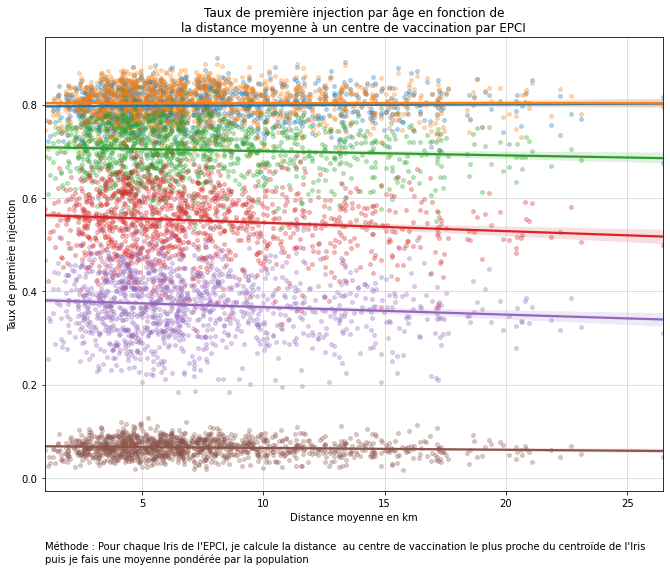

In [10]:
#création du grapique

import matplotlib.pyplot as plt
import seaborn as sns



fig,ax1 = plt.subplots(figsize=(10,8))
for age in data["classe_age"].sort_values(ascending=False).unique():

    d = data[(data['classe_age'] == age)]
    sns.regplot(data=d, x="weighted",y="taux_cumu_1_inj",scatter_kws={'alpha':0.3, "s" : 15},ax=ax1,label=age)
    
ax1.set_title("Taux de première injection par âge en fonction de\nla distance moyenne à un centre de vaccination par EPCI")
ax1.set_xlabel("Distance moyenne en km")
ax1.set_ylabel("Taux de première injection")
ax1.grid(alpha=0.5)
ax1.text(1,-0.18,"Méthode : Pour chaque Iris de l'EPCI, je calcule la distance  au centre de vaccination le plus proche du centroïde de l'Iris\npuis je fais une moyenne pondérée par la population")
plt.tight_layout()
fig.savefig("distance vax.png",facecolor="w",dpi=150)

In [21]:
average_dist.sort_values()

EPCI
200054781     0.990231
200068047     1.128440
249500109     1.155982
242000354     1.228601
200058477     1.313331
               ...    
200069458    21.855487
243800745    22.228395
200071777    22.679879
200044253    23.112272
241200542    26.476255
Name: weighted, Length: 1232, dtype: float64

In [84]:
data

,date_reference,semaine_injection,epci,libelle_epci,population_carto,classe_age,libelle_classe_age,effectif_1_inj,effectif_termine,effectif_cumu_1_inj,effectif_cumu_termine,taux_1_inj,taux_termine,taux_cumu_1_inj,taux_cumu_termine,date,reg_code,weighted
82260,2021-06-27,2021-18,200068278,CC BERRY LOIRE PUISAYE,3010,40-54,de 40 à 54 ans,130.0,30.0,400.0,150.0,0.043,0.010,0.134,0.048,2021-05-09,24,12488.575285
82263,2021-06-27,2021-18,200068278,CC BERRY LOIRE PUISAYE,2370,55-64,de 55 à 64 ans,170.0,40.0,1010.0,210.0,0.072,0.018,0.426,0.087,2021-05-09,24,12488.575285
155542,2021-06-27,2021-18,200068278,CC BERRY LOIRE PUISAYE,2590,65-74,de 65 à 74 ans,140.0,180.0,1670.0,480.0,0.054,0.070,0.647,0.185,2021-05-09,24,12488.575285
155545,2021-06-27,2021-18,200068278,CC BERRY LOIRE PUISAYE,2510,75 et +,75 ans et plus,100.0,140.0,1830.0,1420.0,0.040,0.055,0.728,0.567,2021-05-09,24,12488.575285
179806,2021-06-27,2021-18,200068278,CC BERRY LOIRE PUISAYE,3240,00-19,moins de 20 ans,NaN,NaN,NaN,NaN,0.001,NaN,0.002,NaN,2021-05-09,24,12488.575285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161248,2021-06-27,2021-18,249500455,CC DE LA VALLEE DE L OISE ET DES TROIS FORETS,8160,40-54,de 40 à 54 ans,490.0,170.0,1710.0,670.0,0.060,0.021,0.210,0.082,2021-05-09,11,1873.885432
161251,2021-06-27,2021-18,249500455,CC DE LA VALLEE DE L OISE ET DES TROIS FORETS,5170,55-64,de 55 à 64 ans,440.0,160.0,2690.0,710.0,0.084,0.031,0.520,0.137,2021-05-09,11,1873.885432
181648,2021-06-27,2021-18,249500455,CC DE LA VALLEE DE L OISE ET DES TROIS FORETS,9170,00-19,moins de 20 ans,NaN,NaN,20.0,NaN,0.001,0.000,0.003,0.001,2021-05-09,11,1873.885432
181649,2021-06-27,2021-18,249500455,CC DE LA VALLEE DE L OISE ET DES TROIS FORETS,4010,65-74,de 65 à 74 ans,210.0,270.0,2880.0,1140.0,0.052,0.068,0.719,0.285,2021-05-09,11,1873.885432
